# Chapter 6 Time Series Forecasting
## Section 6.1 and 6.2 
## Prediction of demand with an ARIMA Model

In [1]:
#import packages
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt 
import statsmodels
import datetime as dt
import os
import warnings



In [2]:
print(statsmodels.__version__)
print(pd.__version__)
print(np.__version__)
print(gpd.__version__)



0.13.2
1.4.2
1.21.6
0.10.2


In [3]:
warnings.filterwarnings("ignore")

In [4]:
%store -r c_co_in
%store -r c_co_out

In [5]:
# get daily max check-outs
ops_day=c_co_out.groupby(c_co_out['OwnerSince'].dt.date).size().to_frame('count_')
ops_day['check_ins']=c_co_in.groupby(c_co_in['OwnerTill'].dt.date).size()
ops_day['date']=pd.to_datetime(ops_day.index)
print(ops_day.shape)
ops_day.head()

(837, 3)


,count_,check_ins,date
OwnerSince,,,
2019-09-23,62,1.0,2019-09-23
2019-09-24,13,1.0,2019-09-24
2019-09-25,21,8.0,2019-09-25
2019-09-26,19,9.0,2019-09-26
2019-09-27,15,11.0,2019-09-27


In [6]:
ops_day.tail()

,count_,check_ins,date
OwnerSince,,,
2022-02-28,123,172.0,2022-02-28
2022-03-01,417,453.0,2022-03-01
2022-03-02,377,478.0,2022-03-02
2022-03-03,244,485.0,2022-03-03
2022-03-04,78,362.0,2022-03-04


In [7]:
# create a bin including empty days between the range of earliest and latest day that a transaction took place
bins=pd.date_range(start=pd.to_datetime(ops_day.index).min(), end=pd.to_datetime(ops_day.index).max())
bins=pd.to_datetime(bins)
bins=pd.Series(bins).dt.date
bins=pd.DataFrame(bins, columns=['date'])


# add this bin as an index into df with merge operation
# now, we have all days in the df
ops_day['date']=pd.to_datetime(ops_day.index)
ops_day['date']=ops_day['date'].dt.date
ops_day.index=ops_day['date']

ops_day=pd.merge(bins,ops_day, how='left', left_on=bins['date'], \
                 right_index=True).fillna(0).drop(['date_y'], axis=1).rename(columns={'date_x':'date'}).set_index('date')
ops_day['date']=pd.to_datetime(ops_day.index)
print(ops_day.shape)

(894, 3)


In [8]:
# Corona cases
df=pd.read_csv('Aktuell_Deutschland_SarsCov2_Infektionen.csv')
df['Meldedatum']= pd.to_datetime(df['Meldedatum'])
df['Refdatum']= pd.to_datetime(df['Refdatum'])



cdf=df[(df['IdLandkreis']==5315)].groupby(df['Meldedatum'].dt.date)['AnzahlFall'].sum().to_frame('corona')



# join with ops transactional data
ops_day=ops_day.join(cdf, how='left')#.drop('key_0', axis=1)

ops_day.tail()

,count_,check_ins,date,corona
date,,,,
2022-02-28,123.0,172.0,2022-02-28,1620.0
2022-03-01,417.0,453.0,2022-03-01,3028.0
2022-03-02,377.0,478.0,2022-03-02,3821.0
2022-03-03,244.0,485.0,2022-03-03,6851.0
2022-03-04,78.0,362.0,2022-03-04,4985.0


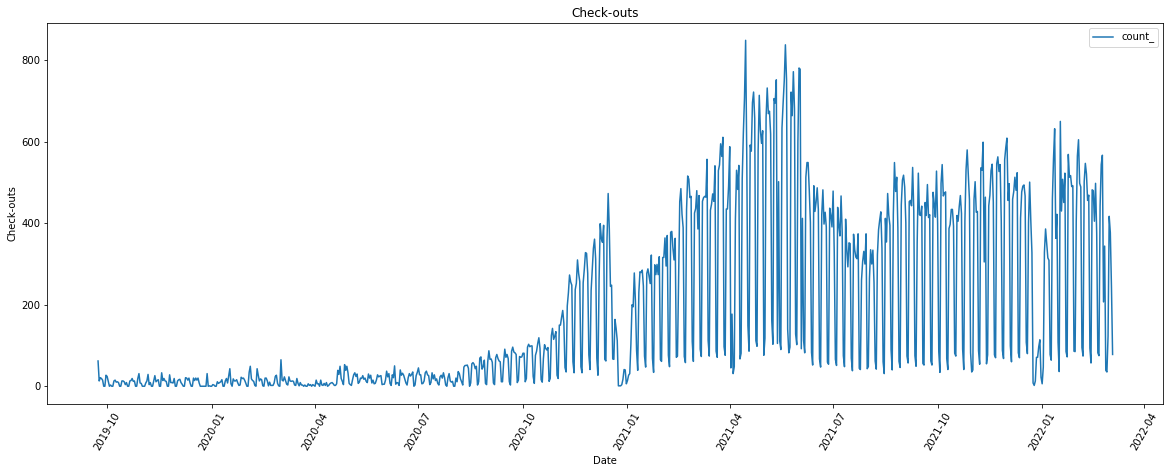

In [9]:
# plot
ops_day[['count_']].plot(figsize=(20,7) )
plt.xticks(rotation=60)
plt.title('Check-outs')
plt.xlabel('Date')
plt.ylabel('Check-outs')
plt.show()

In [10]:
# 7_day_corona cases 
for i,row in ops_day.iterrows():
    ops_day.loc[i,'7_day']=ops_day[:i].tail(7)['corona'].mean()

ops_day.tail()

,count_,check_ins,date,corona,7_day
date,,,,,
2022-02-28,123.0,172.0,2022-02-28,1620.0,1670.000000
2022-03-01,417.0,453.0,2022-03-01,3028.0,1782.285714
2022-03-02,377.0,478.0,2022-03-02,3821.0,1996.000000
2022-03-03,244.0,485.0,2022-03-03,6851.0,2724.714286
2022-03-04,78.0,362.0,2022-03-04,4985.0,3173.000000


In [11]:
# crop the series
last_date=dt.datetime(2022, 3, 1).date()
ops_day=ops_day[ops_day.index<=last_date]

In [12]:
# group by week
ops_week=ops_day.groupby([ops_day['date'].dt.year, ops_day['date'].dt.isocalendar().week]).max()

ops_week['year_week']=ops_week.index

ops_week.tail()

ops_week.drop((2022, 52), inplace=True) # remove 52nd week from 2022? 
ops_week.tail()

count_  check_ins       date  corona        7_day  year_week
date week                                                              
2022 5      605.0      510.0 2022-02-06  4138.0  2855.857143  (2022, 5)
     6      547.0      543.0 2022-02-13  3566.0  2926.571429  (2022, 6)
     7      498.0      524.0 2022-02-20  2842.0  2471.000000  (2022, 7)
     8      567.0      570.0 2022-02-27  2325.0  1922.571429  (2022, 8)
     9      417.0      453.0 2022-03-01  3028.0  1782.285714  (2022, 9)

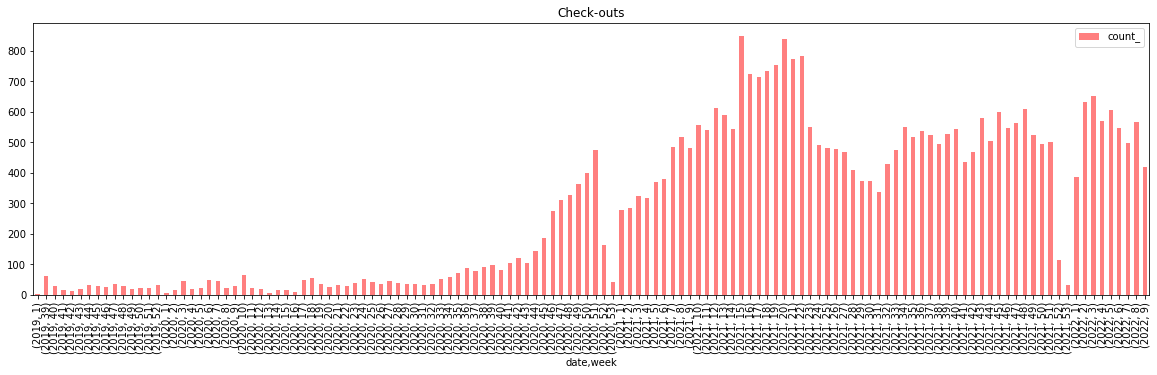

In [13]:
# plot

plt.figure(figsize=(20, 5))
plt.title('Check-outs')
ops_week['count_'].plot.bar(color='Red', legend=True,  alpha=0.5)
ops_week.index.names = ['year','week']

plt.show()


<AxesSubplot:title={'center':'Check-outs'}, xlabel='year,week'>

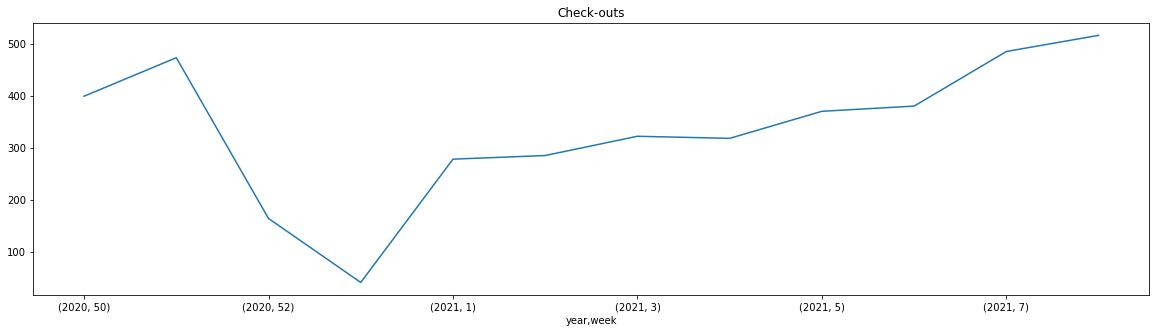

In [14]:
# plot

plt.figure(figsize=(20, 5))
plt.title('Check-outs')
ops_week[(2020,50):(2021,8)]['count_'].plot()

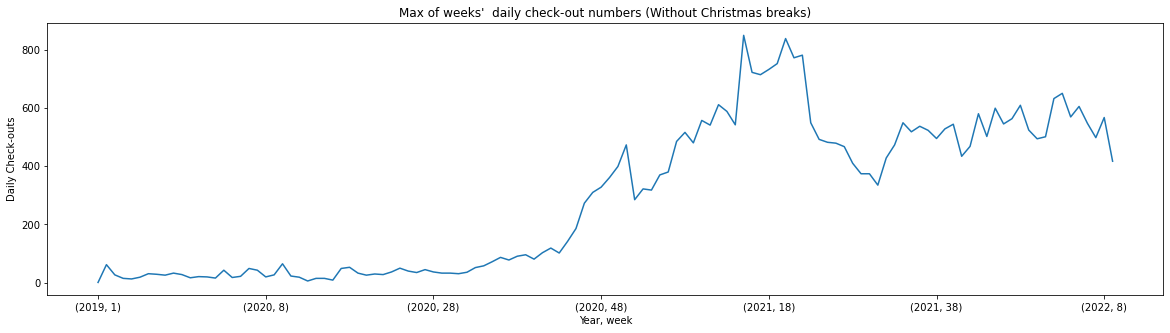

In [15]:
# Since we know drops at christmas time, we drop them...
#ops=ops_week[(2021,40):(2022,8)]['count_'].drop([(2021,52),(2021,53),(2022,1)]).reset_index()['count_']
ops=ops_week.drop([(2019,52),(2020,1),(2020,52),(2020,53),(2021,1),(2021,52),(2021,53),(2022,1)])
#ops=ops_week.drop([(2020,53),(2021,53)])#.reset_index() # drop fractional weeks 
# plot
plt.figure(figsize=(20, 5))

plt.title("Max of weeks'  daily check-out numbers (Without Christmas breaks)")

ops['count_'].plot()
plt.xlabel('Year, week')
plt.ylabel('Daily Check-outs')
plt.show()

<Figure size 720x360 with 0 Axes>

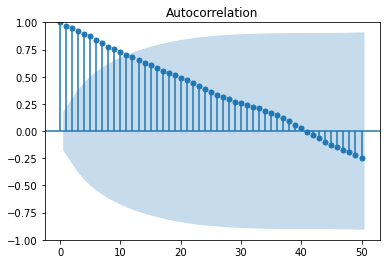

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(10, 5))
#plt.title('Autocorrelation')
plot_acf(ops['count_'], lags=50)
plt.show()

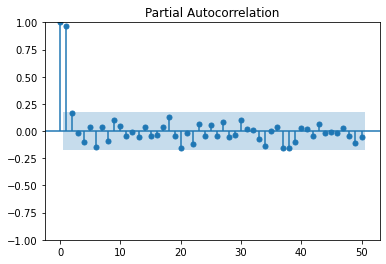

In [17]:
p=plot_pacf(ops['count_'], method='ywm', lags=50)

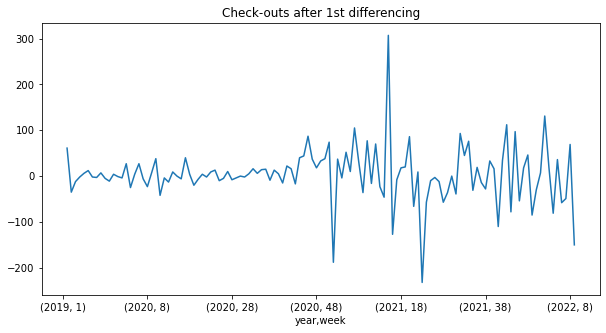

In [18]:
plt.figure(figsize=(10, 5))
plt.title('Check-outs after 1st differencing')
ops['count_'].diff().plot()
plt.show()

In [47]:
# adf füller test
from statsmodels.tsa.stattools import adfuller, kpss

print('ADF without differencing:',adfuller(ops['count_'].dropna())[1]) # p-value is not significant. 
print('ADF 1st differencing:',adfuller(ops['count_'].diff().dropna())[1]) # p-value is significant
# The series is stationary...

print('KPSS without differencing:',kpss(ops['count_'].dropna())[1]) # p-value is not significant. 
print('KPSS 1st differencing:',kpss(ops['count_'].diff().dropna())[1]) # p-value is significant

ADF without differencing: 0.7020704642633246
ADF 1st differencing: 2.8187871855504284e-25
KPSS without differencing: 0.01
KPSS 1st differencing: 0.1


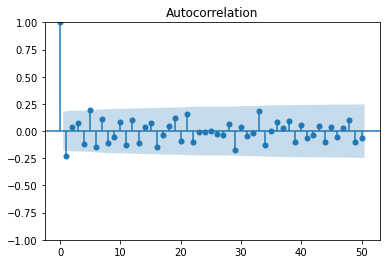

In [49]:

# Autocorrelation plot
p=plot_acf(ops['count_'].diff().dropna(), lags=50)


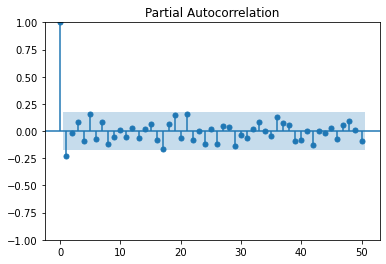

In [21]:
# partial autocorrelation plot
p=plot_pacf(ops['count_'].diff().dropna(), method='ywm', lags=50) # 1st differencing

In [22]:
ops=ops.set_index('year_week')
ops.tail()

,count_,check_ins,date,corona,7_day
year_week,,,,,
"(2022, 5)",605.0,510.0,2022-02-06,4138.0,2855.857143
"(2022, 6)",547.0,543.0,2022-02-13,3566.0,2926.571429
"(2022, 7)",498.0,524.0,2022-02-20,2842.0,2471.000000
"(2022, 8)",567.0,570.0,2022-02-27,2325.0,1922.571429
"(2022, 9)",417.0,453.0,2022-03-01,3028.0,1782.285714


                               SARIMAX Results                                
Dep. Variable:                 count_   No. Observations:                  122
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -662.195
Date:                Wed, 06 Jul 2022   AIC                           1330.390
Time:                        06:53:59   BIC                           1338.777
Sample:                             0   HQIC                          1333.796
                                - 122                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2149      0.422     -0.509      0.610      -1.041       0.612
ma.L1         -0.0206      0.417     -0.049      0.961      -0.837       0.796
sigma2      3317.7059    211.614     15.678      0.0

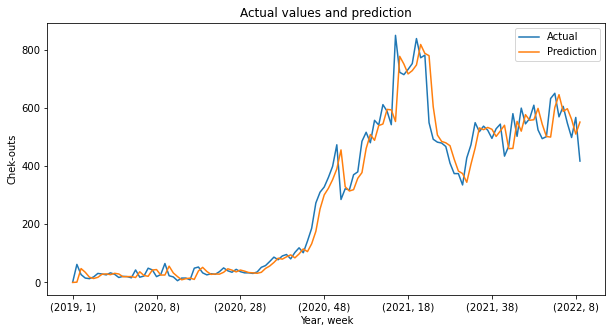

In [24]:
# surpress arnings
warnings.filterwarnings("ignore")
# ARIMA model
from statsmodels.tsa.arima.model import ARIMA
arima_model=ARIMA(ops['count_'], order=(1,1,1))
model=arima_model.fit()

print(model.summary())

fig = plt.figure(figsize=(10,5))
plt.title('Actual values and prediction')
plt.plot(ops['count_'].values ,label='Actual')
pd.Series(model.fittedvalues).plot(label='Prediction') 
plt.ylabel('Chek-outs')
plt.xlabel('Year, week')
plt.legend()
plt.show()

....result...
(2, 1, 2) 1266.6275291588727
                               SARIMAX Results                                
Dep. Variable:                 count_   No. Observations:                  117
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -628.314
Date:                Wed, 06 Jul 2022   AIC                           1266.628
Time:                        06:54:28   BIC                           1280.395
Sample:                             0   HQIC                          1272.217
                                - 117                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7648      0.055    -32.336      0.000      -1.872      -1.658
ar.L2         -0.9516      0.049    -19.539      0.000      -1.047      -0.856
ma.L1    

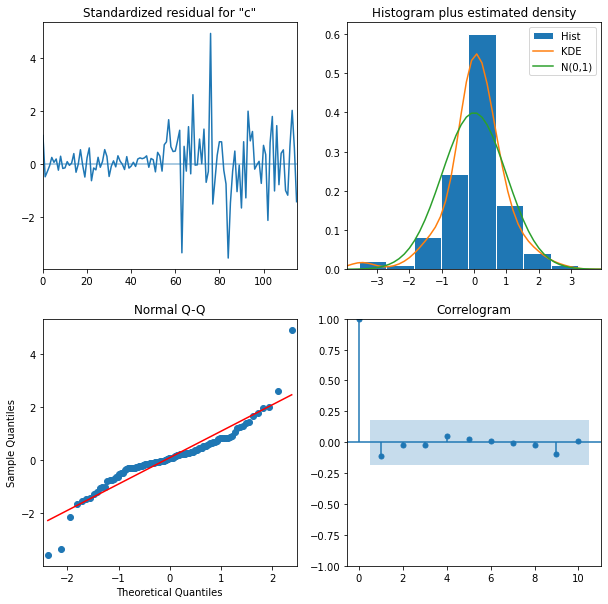

In [25]:
#split data for train and test
train_break=(2022,4)

train=ops[:train_break]['count_']

test=ops[train_break:]['count_']


# Grid search to find best parameters

best=10**1000
m_=()
for q in range(3):

    for p in range(3):
        #print(p,1,q)
        arima_model=ARIMA(train,  order=(p,1,q))
        model=arima_model.fit()
        #print(model.aic)
        if model.aic<best:
            best=model.aic
            m_=(p,1,q)
print('....result...')           
print(m_, best)


arima_model=ARIMA(train,  order=m_)
model=arima_model.fit()
print(model.summary())

p=model.plot_diagnostics(figsize=(10,10))

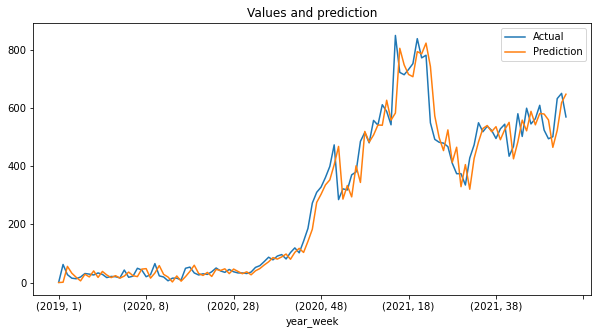

In [26]:
# Plot
fig = plt.figure(figsize=(10,5))
plt.title('Values and prediction')
train.plot(label='Actual')
pd.Series(model.fittedvalues).plot(label='Prediction')
plt.legend()
plt.show()

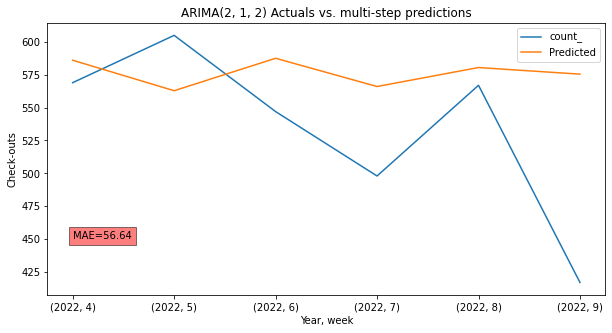

In [27]:
y_pred=pd.Series(model.forecast(steps=test.shape[0]).values, index=test.index, name='Predicted')
y_true=test
mae=np.mean(np.abs(y_pred-y_true)) # mean absolute error
df = pd.concat([y_true, y_pred], axis=1)

df.plot(figsize=(10,5))
plt.title('ARIMA{} Actuals vs. multi-step predictions'.format(m_))
plt.ylabel('Check-outs')
plt.xlabel('Year, week')
plt.text(0, 450, s='MAE={}'.format(round(mae,2)), bbox=dict(facecolor='red', alpha=0.5))
plt.show()

In [28]:
mape=np.mean(np.abs(y_pred-y_true)/np.abs(y_true)) #mean absolute percentage error
mae=np.mean(np.abs(y_pred-y_true)) # mean absolute error
mpe=np.mean((y_pred-y_true)/y_true) # mean percentage error
rmse= np.mean((y_pred-y_true)**2)**0.5
corr=np.corrcoef(y_pred,y_true)[0,1]

n=train.shape[0]
d=np.abs(train.diff()).sum()/(n-1)
errors=np.abs(y_true-y_pred)
mase=errors.mean()/d
print('mase:',mase)
print('mae;',mae)

mase: 1.6039691242212037
mae; 56.63670286905216


# ARIMA with a exegenous regressor

In [29]:
ops_c=ops.loc[(2020,9):(2021,39)] # dropna of corona cases
ops_c


,count_,check_ins,date,corona,7_day
year_week,,,,,
"(2020, 9)",27.0,30.0,2020-03-01,2.0,1.666667
"(2020, 10)",65.0,24.0,2020-03-08,10.0,4.142857
"(2020, 11)",23.0,26.0,2020-03-15,89.0,34.142857
"(2020, 12)",19.0,35.0,2020-03-22,104.0,80.142857
"(2020, 13)",6.0,4.0,2020-03-29,87.0,78.142857
...,...,...,...,...,...
"(2021, 35)",518.0,462.0,2021-09-05,244.0,246.285714
"(2021, 36)",537.0,434.0,2021-09-12,214.0,199.571429
"(2021, 37)",523.0,434.0,2021-09-19,195.0,169.428571


                               SARIMAX Results                                
Dep. Variable:                 count_   No. Observations:                   75
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -405.704
Date:                Wed, 06 Jul 2022   AIC                            823.409
Time:                        06:55:30   BIC                            837.233
Sample:                             0   HQIC                           828.924
                                 - 75                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
7_day          0.2914      0.168      1.731      0.083      -0.039       0.621
ar.L1         -1.6726      0.123    -13.627      0.000      -1.913      -1.432
ar.L2         -0.9090      0.142     -6.391      0.0

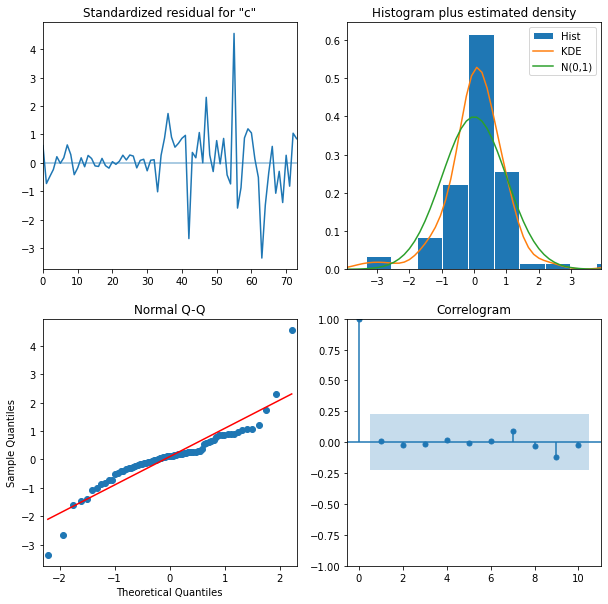

In [34]:
train_break=(2021,33)
target_train=ops_c[:train_break]['count_']
exog_train=ops_c[:train_break][['7_day']]
model = ARIMA(
                target_train,
                exog_train,
                order=(2, 1, 2)).fit()



print(model.summary())
p=model.plot_diagnostics(figsize=(10,10))

Mean Absolute Error 48.777094311325776


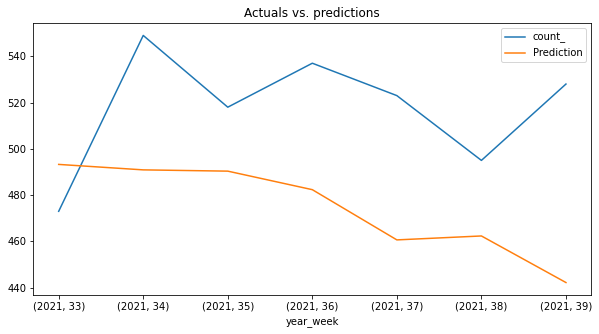

In [35]:
predictions_=model.forecast(steps=ops_c.dropna()[train_break:].shape[0], exog=list(ops_c.dropna()[train_break:][['7_day']].values) ).values
#predictions_
# create a df
y_pred=pd.Series(predictions_, index=ops_c.dropna()[train_break:].index, name='Prediction')
y_true=ops_c.dropna()[train_break:]['count_']


mape=np.mean(np.abs(y_pred-y_true)/np.abs(y_true)) #mean absolute percentage error
mae=np.mean(np.abs(y_pred-y_true)) # mean absolute error
mpe=np.mean((y_pred-y_true)/y_true) # mean percentage error
rmse= np.mean((y_pred-y_true)**2)**0.5
corr=np.corrcoef(y_pred,y_true)[0,1]


print('Mean Absolute Error',mae)

df = pd.concat([y_true, y_pred], axis=1)

df.plot(figsize=(10,5))
plt.title('Actuals vs. predictions')
plt.show()

In [36]:
# Grid search to find best parameters
# Check the contrinution of corona

best=10**1000
train_break=(2021,38)
target_train=ops_c[:train_break]['count_']
exog_train=ops_c[:train_break][['7_day',]]
m_=()
df=pd.DataFrame()
for q in range(3):

    for p in range(3):
        #print('........start.......')
        #print(p,1,q)
        arima_model=ARIMA(target_train,
                exog_train,
            order=(p,1,q))
        model=arima_model.fit()
        
        #print(model.summary())
        #print(model.aic)
        sum_ = pd.read_html(model.summary().tables[1].as_html(),header=None,index_col=0)[0]
        #print('p-value',sum_.iloc[1,3])
        #print('coeff',sum_.iloc[1,0])
        df.loc[str((p,1,q)),'corona_p_value']=sum_.iloc[1,3]
        df.loc[str((p,1,q)),'corona_coeff']=sum_.iloc[1,0]
        df.loc[str((p,1,q)),'AIC']=model.aic
        if model.aic<best:
            best=model.aic
            m_=(p,1,q)
df.index.name='order'
print('....result...')
#print(df)
print('Best:',m_, best)

arima_model=ARIMA(target_train,
                exog_train,
            order=m_)
model=arima_model.fit()
print(model.summary())

df

....result...
Best: (2, 1, 2) 873.7415703721825
                               SARIMAX Results                                
Dep. Variable:                 count_   No. Observations:                   80
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -430.871
Date:                Wed, 06 Jul 2022   AIC                            873.742
Time:                        06:55:34   BIC                            887.958
Sample:                             0   HQIC                           879.437
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
7_day          0.2964      0.154      1.919      0.055      -0.006       0.599
ar.L1         -1.7001      0.102    -16.603      0.000      -1.901      -1.499
ar.L

,corona_p_value,corona_coeff,AIC
order,,,
"(0, 1, 0)",0.028,0.3230,876.725190
"(1, 1, 0)",0.047,0.3114,875.763232
"(2, 1, 0)",0.060,0.3091,877.361755
"(0, 1, 1)",0.041,0.3147,876.212028
"(1, 1, 1)",0.051,0.3107,877.523763
"(2, 1, 1)",0.068,0.3067,879.333982
"(0, 1, 2)",0.070,0.3064,877.311024
"(1, 1, 2)",0.032,0.3270,878.303073
"(2, 1, 2)",0.055,0.2964,873.741570


## Rolling prediction without Exog


....result...
Best: (2, 1, 2) 1254.611550270068
                               SARIMAX Results                                
Dep. Variable:                 count_   No. Observations:                  116
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -622.306
Date:                Wed, 06 Jul 2022   AIC                           1254.612
Time:                        06:55:40   BIC                           1268.336
Sample:                             0   HQIC                          1260.182
                                - 116                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7828      0.049    -36.701      0.000      -1.878      -1.688
ar.L2         -0.9639      0.043    -22.373      0.000      -1.048      -0.880
ma.L

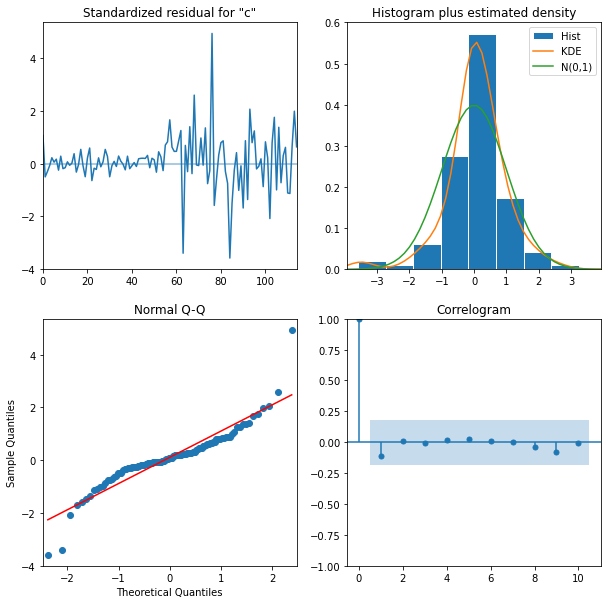

In [37]:
pred_steps=6 # pass how many rolling steps to be predicted


# Grid search to find best parameters
train_break=(ops.tail(pred_steps+1).head(1).index.values)[0]
best=10**1000

target_train=ops[:train_break]['count_']
#exog_train=ops[:train_break][['7_day']]
m_=()
df=pd.DataFrame()
for q in range(3):

    for p in range(3):
        #print('........start.......')
        #print(p,1,q)
        arima_model=ARIMA(target_train,
                #exog_train,
            order=(p,1,q))
        model=arima_model.fit()
        
        
        if model.aic<best:
            best=model.aic
            m_=(p,1,q)

print('....result...')

print('Best:',m_, best)

arima_model=ARIMA(target_train,
                #exog_train,
            order=m_)
model=arima_model.fit()
print(model.summary())
p=model.plot_diagnostics(figsize=(10,10))


In [38]:
m_ # see the best order

(2, 1, 2)

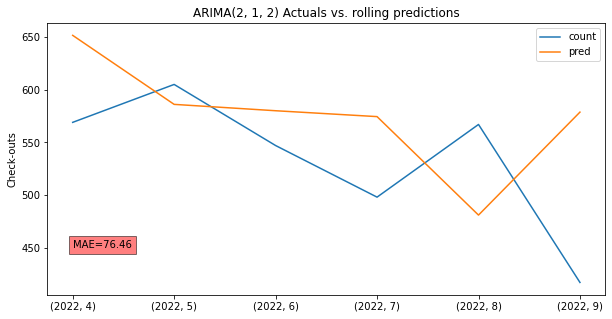

In [39]:
# Rolling prediction 
df=pd.DataFrame()

for i,row in ops.reset_index().tail(pred_steps).iterrows():
    train_break=ops.reset_index().loc[i-1]['year_week']
    model=ARIMA(ops[:train_break]['count_'],order=m_).fit()
    predict=model.forecast(steps=1).values[0]
    df.loc[str(row['year_week']),'pred']=predict
df['count']=ops.tail(pred_steps)['count_'].values
mae=np.mean(np.abs(df['pred'].values-df['count'].values)) # mean absolute error
# plot
#print('Mean Absolute Error:',mae)    
df[['count','pred']].plot( figsize=(10,5))
plt.ylabel('Check-outs')
plt.legend()
plt.title('ARIMA{} Actuals vs. rolling predictions'.format(m_))
plt.text(0, 450, s='MAE={}'.format(round(mae,2)), bbox=dict(facecolor='red', alpha=0.5))
plt.show()

### What if: 
### Fitting an ARIMA Model on series after 1st Oct 2021

In [40]:
train_break=(2021,39)
best=10**1000

target_train=ops[train_break:]['count_']

print('ADF test without differencing:',adfuller(target_train)[1]) # p-value is not significant. 


ADF test without differencing: 0.025669272176180306


....result...
Best: (0, 0, 0) 235.54463185735972
                               SARIMAX Results                                
Dep. Variable:                 count_   No. Observations:                   21
Model:                          ARIMA   Log Likelihood                -115.772
Date:                Wed, 06 Jul 2022   AIC                            235.545
Time:                        06:55:44   BIC                            237.634
Sample:                             0   HQIC                           235.998
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        541.7143     13.340     40.608      0.000     515.568     567.861
sigma2      3597.6781   1314.254      2.737      0.006    1021.787    6173.569
Lju

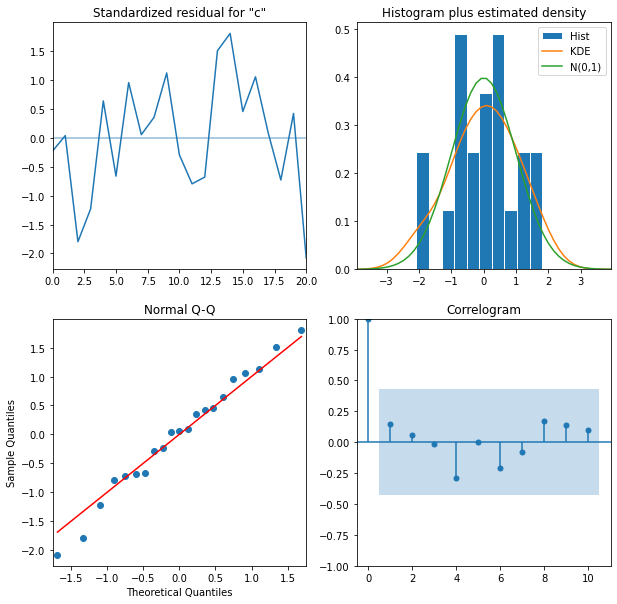

In [41]:
# Grid search to find best parameters


m_=()
df=pd.DataFrame()

for q in range(3):

    for p in range(3):
        

        #print('........start.......')
        #print(p,d,q)
        arima_model=ARIMA(target_train, order=(p,0,q))
        model=arima_model.fit()


        if model.aic<best:
            best=model.aic
            m_=(p,0,q)

print('....result...')

print('Best:',m_, best)

arima_model=ARIMA(target_train,
            
            order=m_)
model=arima_model.fit()
print(model.summary())
p=model.plot_diagnostics(figsize=(10,10))


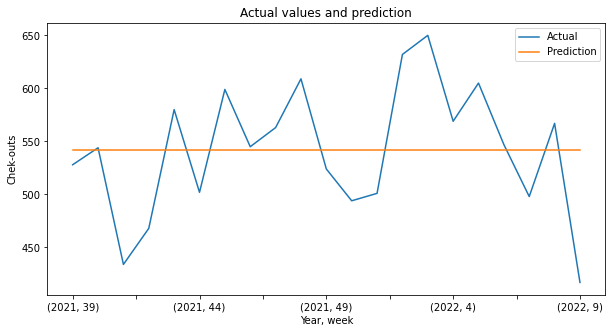

In [42]:
fig = plt.figure(figsize=(10,5))
plt.title('Actual values and prediction')
plt.plot(target_train.values ,label='Actual')
pd.Series(model.fittedvalues).plot(label='Prediction') 
plt.ylabel('Chek-outs')
plt.xlabel('Year, week')
plt.legend()
plt.show()

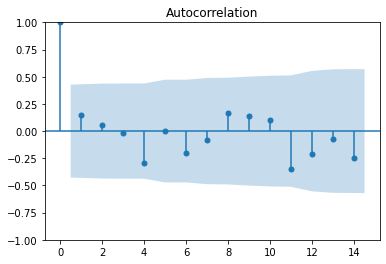

In [43]:
p=plot_acf(target_train)

In [44]:
model.params

const      541.714280
sigma2    3597.678072
dtype: float64

In [45]:
target_train.mean()

541.7142857142857